# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [20]:
# Add your imports here
import pandas as pd
import numpy as np
import scipy as sp
import json
import sqlite3

import findspark
findspark.init()

from pyspark.sql import *
%matplotlib inline

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

**Hint:** Load the dataset from the Parquet file for the next tasks.

In [2]:
DATA = 'data'

In [3]:
stackoverflow = spark.read.json(DATA+'/Posts.json')

In [4]:
stackoverflow.show()

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|2010-10-26T03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|
|2010-10-26T03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|
|2010-10-26T03:19:...|4020440| 4020214|         2|    1|                null|                null|     null|
|2010-10-26T03:19:...|4020441| 3938154|         2|    0|                null|                null|     null|
|2010-10-26T03:20:...|4020443| 4020419|         2|  324|                null|                null|     null|
|2010-10-26T03:20:...|4020444| 4020433|         2|    0|                null|                null|     null|
|2010-10-26T03:21:.

In [5]:
stackoverflow.dtypes

[('CreationDate', 'string'),
 ('Id', 'bigint'),
 ('ParentId', 'bigint'),
 ('PostTypeId', 'bigint'),
 ('Score', 'bigint'),
 ('Tags', 'string'),
 ('Title', 'string'),
 ('ViewCount', 'bigint')]

In [6]:
#Converting CreationDate to numeric format
stackoverflow = stackoverflow.withColumn("CreationDate", unix_timestamp(to_utc_timestamp("CreationDate",'GMT')))
stackoverflow.dtypes

[('CreationDate', 'bigint'),
 ('Id', 'bigint'),
 ('ParentId', 'bigint'),
 ('PostTypeId', 'bigint'),
 ('Score', 'bigint'),
 ('Tags', 'string'),
 ('Title', 'string'),
 ('ViewCount', 'bigint')]

In [7]:
stackoverflow.write.mode('overwrite').parquet("stackoverflow_df.parquet")

In [21]:
stackoverflow = spark.read.parquet("stackoverflow_df.parquet")

In [3]:
stackoverflow_rdd = stackoverflow.rdd

In [10]:
#How many questions and answers?
num_questions = stackoverflow_rdd.filter(lambda r: r[3] == 1).count()
num_answers = stackoverflow_rdd.filter(lambda r: r[3] == 2).count()
print(str(num_questions) + " questions have been asked on Stackoverflow")
print(str(num_answers) + " answers have been given on Stackoverflow")

15647060 questions have been asked on Stackoverflow
25192772 answers have been given on Stackoverflow


In [11]:
q_score0 = stackoverflow_rdd.filter(lambda r: r[3] == 1).filter(lambda r: r[4] == 0).count()
percent_q_score0 = 100 * q_score0 / num_questions
print(str(percent_q_score0) + "% of questions have a score of zero")

46.54365740273253% of questions have a score of zero


### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

In [12]:
#We're only interested in a subset of the data, so lets make it simpler
#Answers aren't tagged, so any non-null values will be questions
tags_rdd = stackoverflow.select("Tags").rdd

In [13]:
#Split the tags into their components
tags_split_rdd = tags_rdd.map(lambda line: str(line).strip().replace('><', ','))
tags_split_rdd = tags_split_rdd.map(lambda line:  str(line)[11:-3])
tags_rdd = tags_split_rdd.flatMap(lambda tag: [(tag[:], tagList) for tagList in tag.split(',')])

In [14]:
#Frequency of each tag and sort (descending)
tag_frequency_rdd = tags_rdd.map(lambda r: (r[1],1)).reduceByKey(lambda a,b: a+b)
tag_frequency_rdd.sortBy(lambda r: r[1], ascending = False).take(10)

[('', 25192772),
 ('javascript', 1585495),
 ('java', 1352735),
 ('c#', 1172492),
 ('php', 1136082),
 ('android', 1088811),
 ('python', 954401),
 ('jquery', 886982),
 ('html', 725289),
 ('ios', 551843)]

The "null" lines are those where the post was an answer

In [15]:
#Count proportion of tags in less than 100 questions
low_freq_tags = tag_frequency_rdd.filter(lambda r: r[1] < 100).count()
total_tags = tag_frequency_rdd.count()
print("There are " + str(low_freq_tags) + " out of " + str(total_tags) + " tags that appear fewer than 100 times.")
print("That is, " + str(100*low_freq_tags/total_tags) + "% of tags appear less than 100 times.")

There are 36025 out of 52995 tags that appear fewer than 100 times.
That is, 67.97811114256062% of tags appear less than 100 times.


In [16]:
tag_frequency_df = spark.createDataFrame(data=tag_frequency_rdd)
tag_frequency_df.write.mode('overwrite').parquet("tag_frequency.parquet")

In [17]:
tag_frequency_df = spark.read.parquet("tag_frequency.parquet")

In [18]:
#We need the data as a pandas dataframe to be able to plot it
tag_frequency_pd = tag_frequency_df.toPandas()
tag_frequency_pd.rename(columns={'_1':'Tag', '_2':'Count'}, inplace=True)
tag_frequency_pd.head()

,Tag,Count
0,share,3668
1,subscription,1155
2,loops,53308
3,excel-formula,14803
4,python-2.7,80712


Text(0.5,1,'Distribution of tag counts for questions')

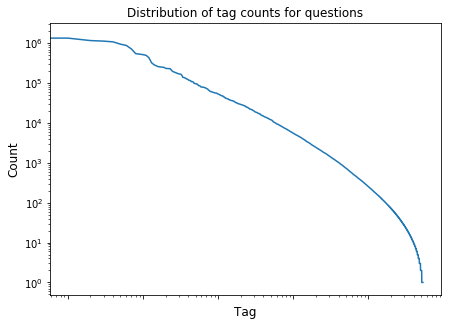

In [19]:
tag_frequency_pd.sort_values(by='Count', ascending=False, inplace=True)
graph1 = tag_frequency_pd[1:].plot(x='Tag', y='Count', figsize = [7, 5], legend = False, loglog = True)
graph1.set_xlabel('Tag', fontsize=12)
graph1.set_ylabel('Count', fontsize=12)
graph1.set_title('Distribution of tag counts for questions', fontsize=12)

Text(0.5,1,'Top 10 tags for questions on Stackoverflow')

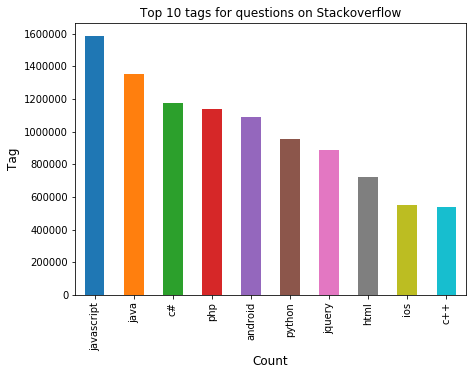

In [20]:
graph2 = tag_frequency_pd[1:11].plot('Tag', 'Count', figsize=[7, 5], legend=False, kind='bar')
graph2.set_xlabel('Count', fontsize=12)
graph2.set_ylabel('Tag', fontsize=12)
graph2.set_title('Top 10 tags for questions on Stackoverflow', fontsize=12)

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

**Hint:** Inspect the data visually before drawing your conclusions.

In [26]:
temporary_rdd = stackoverflow.select('Score', 'Tags', 'ViewCount').rdd
random_effects_rdd = temporary_rdd.filter(lambda line: 'random-effects' in str(line))

In [29]:
random_effects = spark.createDataFrame(data=random_effects_rdd)
random_effects_pd = random_effects.toPandas()

Text(0.5,1,'Relationship between number of views and score for post with the tag random-effects')

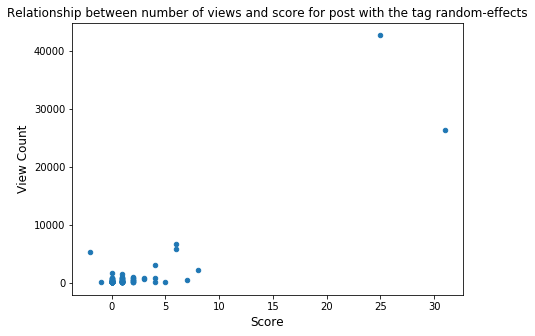

In [33]:
graph3 = random_effects_pd.plot('Score', 'ViewCount', figsize=[7, 5], kind='scatter')
graph3.set_ylabel('View Count', fontsize=12)
graph3.set_xlabel('Score', fontsize=12)
graph3.set_title('Relationship between number of views and score for post with the tag random-effects')

In [34]:
random_effects_pd.corr(method='pearson')

,Score,ViewCount
Score,1.000000,0.882197
ViewCount,0.882197,1.000000


### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python. Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
3. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


In [22]:
#Questions tagged respectively with python or java
posts_rdd = stackoverflow.select('CreationDate', 'Id', 'Tags', 'PostTypeId').rdd
python_rdd = posts_rdd.filter(lambda r: r[3] == 1).filter(lambda line: 'python' in str(line))
python = spark.createDataFrame(data=python_rdd)
java_rdd = posts_rdd.filter(lambda r: r[3] == 1).filter(lambda line: 'java' in str(line))
java = spark.createDataFrame(data=java_rdd)

**Fastest response time: group by parent ID and keep only earliest CreationDate. Join with dataframe containing questions. Calculate difference in creation dates. Filter for positive results.**

In [23]:
#All fastest answers
answers_rdd = posts_rdd.filter(lambda r: r[3] == 2)
answers = spark.createDataFrame(data=answers_rdd, schema=stackoverflow.schema)
fastest_answers = answers.groupBy('ParentId').agg(min('CreationDate'))

In [24]:
fastest_answers = fastest_answers.toDF("Id", "FirstAnswer")

In [25]:
python_answers = python.join(fastest_answers, on="Id", how='inner')

### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?
